## Adding `MLFlow`

### Import necessary modules

In [33]:
import nltk
import string
from nltk.corpus import stopwords
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_recall_curve, auc
import mlflow
import mlflow.sklearn
import warnings
import prettytable

# Filter warnings
warnings.filterwarnings('ignore')

### Load the data

In [7]:
train_df = pd.read_csv('sms-spam-collection/train.csv')
val_df = pd.read_csv('sms-spam-collection/val.csv')
test_df = pd.read_csv('sms-spam-collection/test.csv')

In [8]:
train_df['category'] = (train_df['category'] == 'spam').astype(int)
test_df['category'] = (test_df['category'] == 'spam').astype(int)
val_df['category'] = (val_df['category'] == 'spam').astype(int)


##### Drop rows with `missing values`

In [9]:
train_df.dropna(inplace=True)
val_df.dropna(inplace=True)
test_df.dropna(inplace=True)

##### Merging `train` and `val` set.

In [10]:
train_df = pd.concat([train_df, val_df])

## Text processing

In [11]:
def process_text(text):
    text = text.lower()
    words = nltk.word_tokenize(text)

    processed_text = [
        word for word in words 
        if (word.isalnum() 
            and word not in stopwords.words('english') 
            and word not in string.punctuation)
    ]
    
    return ' '.join(processed_text)

train_df['processed_message'] = train_df['message'].apply(process_text)
test_df['processed_message'] = test_df['message'].apply(process_text)
val_df['processed_message'] = val_df['message'].apply(process_text)
train_df.drop('message', axis=1, inplace=True)
test_df.drop('message', axis=1, inplace=True) 
val_df.drop('message', axis=1, inplace=True)

## Feature extraction

In [12]:
tfidf_vectorizer = TfidfVectorizer()

# Fit and transform the training data
train_tfidf = tfidf_vectorizer.fit_transform(train_df['processed_message'])

# Transform the test and val data
val_tfidf = tfidf_vectorizer.transform(val_df['processed_message'])
test_tfidf = tfidf_vectorizer.transform(test_df['processed_message'])

print(train_tfidf.shape)
print(val_tfidf.shape)
print(test_tfidf.shape)

(4457, 7103)
(557, 7103)
(1115, 7103)


## Training and evaluating a few benchmark models 

#### MLflow Configuration and Model Tracking

MLflow is used to track experiments, record metrics, and manage model artifacts:

- `mlflow ui` sets up a local server.
- Tracking URI is set to local server (http://localhost:5000)
- Experiment name: "SMS Spam Detection"
- For each model (Logistic Regression, Decision Tree, Random Forest, SVM):
    - Hyperparameters are tuned using GridSearchCV
    - Best parameters and ROC-AUC scores are logged
    - Models are registered in MLflow registry
    - Training and Test AUCPR metrics are tracked
    - Model artifacts are saved for deployment

In [4]:
mlflow.set_tracking_uri("http://127.0.0.1:5000")
mlflow.set_experiment("SMS Spam Detection")

2025/03/04 23:23:39 INFO mlflow.tracking.fluent: Experiment with name 'SMS Spam Detection' does not exist. Creating a new experiment.


<Experiment: artifact_location='mlflow-artifacts:/653745853995064246', creation_time=1741110819041, experiment_id='653745853995064246', last_update_time=1741110819041, lifecycle_stage='active', name='SMS Spam Detection', tags={}>

#### Defining `train` and `evaluate` functions

In [13]:
def fine_tune_model(model, param_grid, train_tfidf, train_labels):
    """
    Perform grid search and return the best estimator
    """
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, 
                                    scoring='roc_auc', cv=5, n_jobs=-1, verbose=2)
    grid_search.fit(train_tfidf, train_labels)    
    best_model = grid_search.best_estimator_
        
    mlflow.log_params(grid_search.best_params_)
    mlflow.log_param("model_name", model.__class__.__name__)
    mlflow.log_metric("best roc_auc score", grid_search.best_score_)

    mlflow.sklearn.log_model(best_model, "model")
        
    print("Best Parameters:", grid_search.best_params_)
    print("Best roc_auc score:", grid_search.best_score_)
        
    return best_model

def evaluate_model(model, X, y, label=""):
    """
    Evaluate model performance and plot confusion matrix for a given dataset
    
    Args:
        model: trained model object
        X: features (tfidf matrix)
        y: true labels
        label: dataset label (e.g., "Training" or "Test")
    """
    predictions = model.predict(X)

    precision, recall, _ = precision_recall_curve(y, predictions)
    auprc = auc(recall, precision)
    mlflow.log_metric(f"{label}_aucpr", auprc)
    
    return auprc

#### Logistic Regression

In [14]:
with mlflow.start_run(run_name="Logistic Regression"):
    lr = LogisticRegression()
    param_grid_lr = {
        'penalty': ['l1', 'l2', 'elasticnet'],
        'C': [0.01, 0.1, 1, 10],
        'solver': ['newton-cg', 'saga']
    }

    best_lr = fine_tune_model(lr, param_grid_lr, train_tfidf, train_df['category'])
    train_aucpr = evaluate_model(best_lr, train_tfidf, train_df['category'], "Training")
    test_aucpr = evaluate_model(best_lr, test_tfidf, test_df['category'], "Test")

    model_uri = f"runs:/{mlflow.active_run().info.run_id}/model"
    mlflow.register_model(model_uri, "SMS_Spam_Detection_Logistic_Regression")
    
    print(f"Training AUCPR: {train_aucpr}")
    print(f"Test AUCPR: {test_aucpr}")

mlflow.end_run()

Fitting 5 folds for each of 24 candidates, totalling 120 fits


2025/03/04 23:26:44 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Successfully registered model 'SMS_Spam_Detection_Logistic_Regression'.
2025/03/04 23:26:44 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: SMS_Spam_Detection_Logistic_Regression, version 1


Best Parameters: {'C': 10, 'penalty': 'l2', 'solver': 'newton-cg'}
Best roc_auc score: 0.9887153693876762
Training AUCPR: 0.9969892618698633
Test AUCPR: 0.9328542495003506
🏃 View run Logistic Regression at: http://127.0.0.1:5000/#/experiments/653745853995064246/runs/b8736c8afd724d4c816a67561702c7f3
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/653745853995064246


Created version '1' of model 'SMS_Spam_Detection_Logistic_Regression'.


#### Decision tree

In [15]:
with mlflow.start_run(run_name="Decision Tree"):
    dt = DecisionTreeClassifier()
    param_grid_dt = {
        'criterion': ['gini', 'entropy'],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5],
        'min_samples_leaf': [1, 2, 4]
    }

    best_dt = fine_tune_model(dt, param_grid_dt, train_tfidf, train_df['category'])
    train_aucpr = evaluate_model(best_dt, train_tfidf, train_df['category'], "Training")
    test_aucpr = evaluate_model(best_dt, test_tfidf, test_df['category'], "Test")

    model_uri = f"runs:/{mlflow.active_run().info.run_id}/model"
    mlflow.register_model(model_uri, "SMS_Spam_Detection_Decision_Tree")
    
    print(f"Training AUCPR: {train_aucpr}")
    print(f"Test AUCPR: {test_aucpr}")

mlflow.end_run()

Fitting 5 folds for each of 48 candidates, totalling 240 fits


2025/03/04 23:27:36 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Successfully registered model 'SMS_Spam_Detection_Decision_Tree'.
2025/03/04 23:27:36 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: SMS_Spam_Detection_Decision_Tree, version 1


Best Parameters: {'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 2}
Best roc_auc score: 0.933229756380755
Training AUCPR: 0.8986980736971734
Test AUCPR: 0.8143037969956278
🏃 View run Decision Tree at: http://127.0.0.1:5000/#/experiments/653745853995064246/runs/8bbd606421f247d7a2b67b0a9441ada8
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/653745853995064246


Created version '1' of model 'SMS_Spam_Detection_Decision_Tree'.


#### Random forest

In [17]:
with mlflow.start_run(run_name="Random Forest"):
    rf = RandomForestClassifier()
    param_grid_rf = {
        'n_estimators': [100, 200],
        'criterion': ['gini', 'entropy'],
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5],
        'min_samples_leaf': [1, 2, 4]
    }

    best_rf = fine_tune_model(rf, param_grid_rf, train_tfidf, train_df['category'])
    train_aucpr = evaluate_model(best_rf, train_tfidf, train_df['category'], "Training")
    test_aucpr = evaluate_model(best_rf, test_tfidf, test_df['category'], "Test")

    model_uri = f"runs:/{mlflow.active_run().info.run_id}/model"
    mlflow.register_model(model_uri, "SMS_Spam_Detection_Random_Forest")
    
    print(f"Training AUCPR: {train_aucpr}")
    print(f"Test AUCPR: {test_aucpr}")

mlflow.end_run()

Fitting 5 folds for each of 72 candidates, totalling 360 fits


2025/03/04 23:33:05 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Best Parameters: {'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}
Best roc_auc score: 0.9896120150260328


Successfully registered model 'SMS_Spam_Detection_Random_Forest'.
2025/03/04 23:33:05 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: SMS_Spam_Detection_Random_Forest, version 1


Training AUCPR: 0.9992760626814533
Test AUCPR: 0.9418545159057393
🏃 View run Random Forest at: http://127.0.0.1:5000/#/experiments/653745853995064246/runs/76e72d84421e4b0da99c4c7c43dd0e81
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/653745853995064246


Created version '1' of model 'SMS_Spam_Detection_Random_Forest'.


#### Support Vector Machine

In [16]:
with mlflow.start_run(run_name="SVM"):
    svm = SVC()
    param_grid_svm = {
        'C': [0.1, 1],
        'kernel': ['linear', 'rbf'],
        'gamma': ['scale', 'auto']
    }

    best_svm = fine_tune_model(svm, param_grid_svm, train_tfidf, train_df['category'])
    train_aucpr = evaluate_model(best_svm, train_tfidf, train_df['category'], "Training")
    test_aucpr = evaluate_model(best_svm, test_tfidf, test_df['category'], "Test")

    model_uri = f"runs:/{mlflow.active_run().info.run_id}/model"
    mlflow.register_model(model_uri, "SMS_Spam_Detection_SVM")
    
    print(f"Training AUCPR: {train_aucpr}")
    print(f"Test AUCPR: {test_aucpr}")

mlflow.end_run()


Fitting 5 folds for each of 8 candidates, totalling 40 fits


2025/03/04 23:28:43 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Best Parameters: {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}
Best roc_auc score: 0.9908937145922124


Successfully registered model 'SMS_Spam_Detection_SVM'.
2025/03/04 23:28:46 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: SMS_Spam_Detection_SVM, version 1


Training AUCPR: 0.9927606268145333
Test AUCPR: 0.9418545159057393
🏃 View run SVM at: http://127.0.0.1:5000/#/experiments/653745853995064246/runs/c30931eea31a4342a47909f471656e81
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/653745853995064246


Created version '1' of model 'SMS_Spam_Detection_SVM'.


### Printing `AUCPR` for benchmark models

#### Utility function for plotting `aucpr`

In [29]:
def plot_auc_pr(y_test, y_pred, title):
    """
    Plot the Precision-Recall curve and compute the AUC-PR.

    Args:
        y_test (array-like): True binary labels.
        y_pred (array-like): Predicted probabilities or binary labels.
        title (str): Title for the plot.
    """

    precision, recall, _ = precision_recall_curve(y_test, y_pred)
    
    auc_pr = auc(recall, precision)
    
    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, color='blue', lw=2, label=f'AUC-PR = {auc_pr:.2f}')
    plt.fill_between(recall, precision, alpha=0.2, color='blue')
    
    plt.xlabel('Recall', fontsize=12)
    plt.ylabel('Precision', fontsize=12)
    plt.title(f"Precision-Recall Curve for {title}", fontsize=14)
    plt.legend(loc='lower left', fontsize=12)
    plt.grid(True)
    plt.show()

    return auc_pr

In [30]:
runs_models_mapping = [
    {"run_id": "b8736c8afd724d4c816a67561702c7f3", "model_name": "Logistic Regression"},
    {"run_id": "8bbd606421f247d7a2b67b0a9441ada8", "model_name": "Decision Tree"},
    {"run_id": "76e72d84421e4b0da99c4c7c43dd0e81", "model_name": "Random Forest"},
    {"run_id": "c30931eea31a4342a47909f471656e81", "model_name": "SVM"}
]

### Plotting the graphs

Logistic Regression:


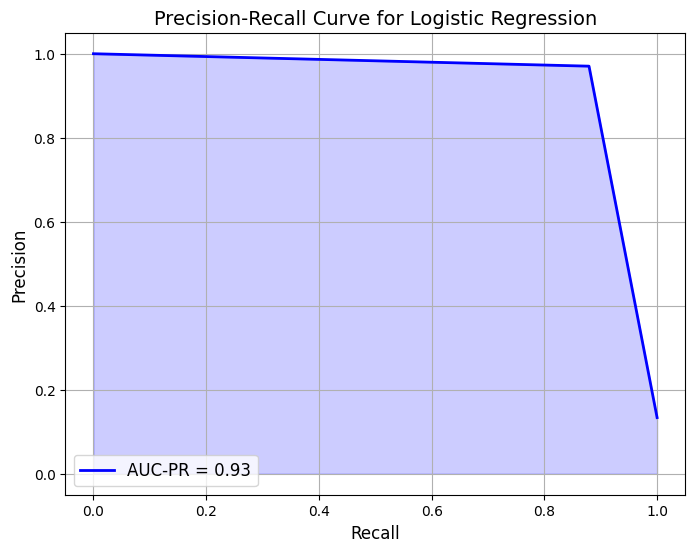

AUCPR: 0.9329



Decision Tree:


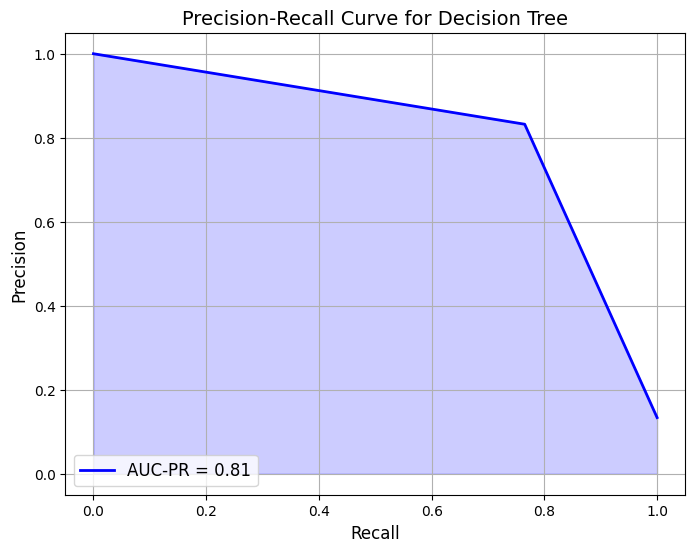

AUCPR: 0.8143



Random Forest:


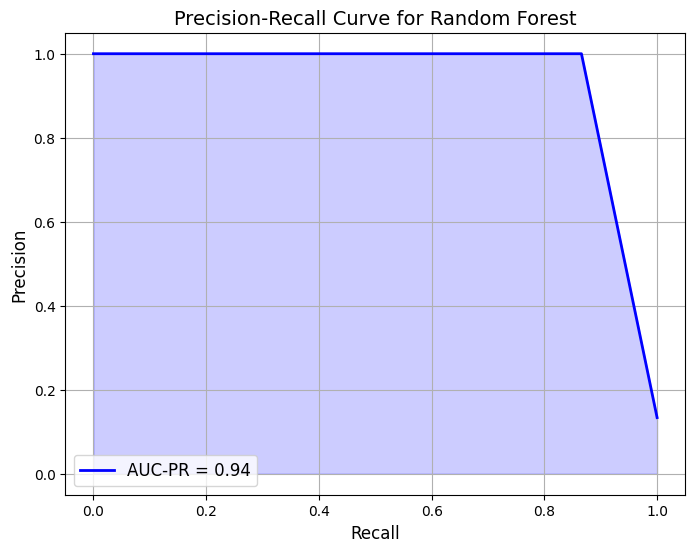

AUCPR: 0.9419



SVM:


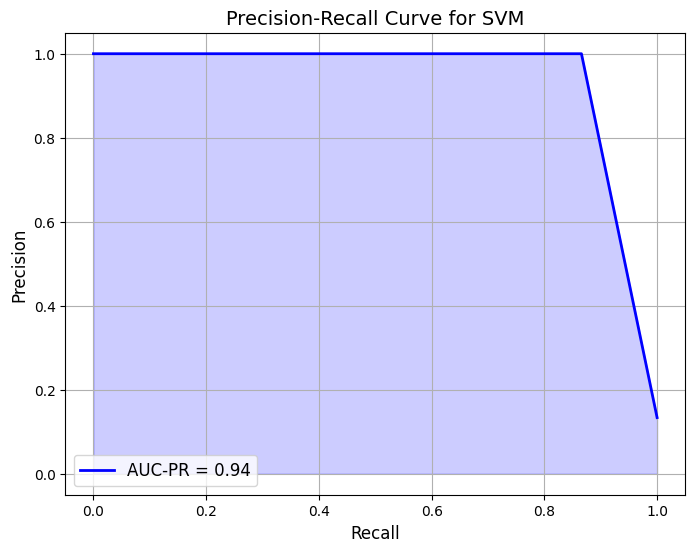

AUCPR: 0.9419



In [34]:
auc_pr_table = prettytable.PrettyTable(["Model", "AUCPR score"])

for model_info in runs_models_mapping:
    model = mlflow.pyfunc.load_model(f"runs:/{model_info['run_id']}/model")
    
    predictions = model.predict(test_tfidf)
    
    print(f"{model_info['model_name']}:")
    aucpr = plot_auc_pr(test_df['category'], predictions, model_info['model_name'])
    print(f"AUCPR: {aucpr:.4f}\n")

    auc_pr_table.add_row([model_info['model_name'], f"{aucpr:.4f}"])


In [35]:
auc_pr_table

Model,AUCPR score
Logistic Regression,0.9329
Decision Tree,0.8143
Random Forest,0.9419
SVM,0.9419


### Model Performance Results

Based on the AUCPR scores, the SVM and Random Forest models performed best (0.9419), followed closely by Logistic Regression (0.9329). The Decision Tree model showed the lowest performance (0.8143) which might be due to overfitting.

Considering that, `SVM` is a simpler model, we will choose `SVM` as the best model.